## NLP on doctor_notes

In [1]:
#import libraries
import pandas as pd
import numpy as np
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from lime.lime_text import LimeTextExplainer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Analysis configuration
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 6)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_csv('data/cleaned_patient_behavior_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       19999 non-null  int64  
 1   gender           19999 non-null  object 
 2   medication       19999 non-null  object 
 3   dose             16651 non-null  object 
 4   name             19999 non-null  object 
 5   surname          19999 non-null  object 
 6   bmi              19999 non-null  float64
 7   weight           19999 non-null  float64
 8   height           19999 non-null  float64
 9   systolic         19999 non-null  int64  
 10  diastolic        19999 non-null  int64  
 11  concentration    19999 non-null  int64  
 12  distractibility  19999 non-null  int64  
 13  impulsivity      19999 non-null  int64  
 14  hyperactivity    19999 non-null  int64  
 15  sleep            19999 non-null  int64  
 16  mood             19999 non-null  int64  
 17  appetite    

In [3]:
# Load scispaCy model 
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz
SCISPACY_MODEL = 'en_core_sci_md' 
nlp_scispaCy = spacy.load(SCISPACY_MODEL)
print(f"Successfully loaded scispaCy model for NER: {SCISPACY_MODEL}")

Successfully loaded scispaCy model for NER: en_core_sci_md


### 1.	Preprocess notes: tokenise, lemmatise, remove stopwords.

In [4]:
def preprocess_text(text):
    """
    Tokenizes, lemmatizes, removes stopwords and punctuation from text.
    Args:
        text (stpip install CMD-V(to paste the copied URL)r): The input string.
    Returns:
        str: The processed string (joined tokens).
    """
    if nlp_scispaCy is None:
        return text # Return original text if spacy model failed to load

    doc = nlp_scispaCy(text.lower()) # Lowercasing
    processed_tokens = []
    for token in doc:
        if not token.is_stop and \
           not token.is_punct and \
           not token.is_space and \
           token.lemma_.strip(): # Check if lemma is not empty after stripping
            processed_tokens.append(token.lemma_)
    return " ".join(processed_tokens)

# Apply preprocessing to a sample to show effect
sample_notes_before = df['doctor_notes'].head(2).tolist()
print(f"Original Note 1: {sample_notes_before[0]}")

# Create a new column for preprocessed notes
df['processed_notes'] = df['doctor_notes'].apply(preprocess_text)

sample_notes_after = df['processed_notes'].head(2).tolist()
print(f"Processed Note 1: {sample_notes_after[0]}")
if len(sample_notes_before) > 1:
    print(f"\nOriginal Note 2: {sample_notes_before[1]}")
    print(f"Processed Note 2: {sample_notes_after[1]}")


df.processed_notes.head()

Original Note 1: Needs review of medication due to side effects. Room care society take admit card scientist budget.
Processed Note 1: need review medication effect room care society admit card scientist budget

Original Note 2: No significant behavioral changes observed. Yeah professional court involve church understand increase must ok.
Processed Note 2: significant behavioral change observe yeah professional court involve church understand increase ok


0    need review medication effect room care societ...
1    significant behavioral change observe yeah pro...
2    mood swing note follow-up set tv fly kid american
3    increase talkativeness interrupting behavior u...
4    significant improvement appetite large signifi...
Name: processed_notes, dtype: object

### 2. Named Entity Recognition (NER)

In [ ]:
# Named Entity Recognition (NER) Function using scispaCy
def extract_medical_entities_scispaCy(text_series):
    """
    Extracts entities using the loaded scispaCy model.
    Args:
        text_series (pd.Series): A pandas Series of text documents.
    Returns:
        pd.DataFrame: DataFrame with original text and extracted entities.
    """
    if nlp_scispaCy is None:
        print("scispaCy model not loaded. Skipping NER.")
        return pd.DataFrame({'text': text_series, 'entities': [[] for _ in range(len(text_series))]})

    results = []
    print("\nExtracting entities using scispaCy model (showing first few examples)...")
    for i, text in enumerate(text_series):
        doc = nlp_scispaCy(text) # Use the loaded scispaCy model
        entities = []
        for ent in doc.ents:
            entities.append({'text': ent.text, 'label': ent.label_})
        results.append({'text': text, 'entities': entities})
        if i < 3: 
             print(f"Text: \"{text[:100]}...\", Entities: {entities}")
    return pd.DataFrame(results)

# Use NER (scispaCy) to extract medical terms
print("\n--- Named Entity Recognition (NER) using scispaCy ---")
extracted_entities_df = extract_medical_entities_scispaCy(df['doctor_notes'].head())


--- 2.2 Named Entity Recognition (NER) using scispaCy ---

Extracting entities using scispaCy model (showing first few examples)...
Text: "Needs review of medication due to side effects. Room care society take admit card scientist budget....", Entities: [{'text': 'Needs review', 'label': 'ENTITY'}, {'text': 'medication', 'label': 'ENTITY'}, {'text': 'side effects', 'label': 'ENTITY'}, {'text': 'Room care society', 'label': 'ENTITY'}, {'text': 'scientist', 'label': 'ENTITY'}, {'text': 'budget', 'label': 'ENTITY'}]
Text: "No significant behavioral changes observed. Yeah professional court involve church understand increa...", Entities: [{'text': 'No significant', 'label': 'ENTITY'}, {'text': 'behavioral', 'label': 'ENTITY'}, {'text': 'changes', 'label': 'ENTITY'}, {'text': 'Yeah professional court', 'label': 'ENTITY'}, {'text': 'church', 'label': 'ENTITY'}, {'text': 'increase', 'label': 'ENTITY'}]
Text: "Mood swings noted during follow-up. Both set TV fly kid American with....", Entitie

### 3.1 Train a model to classify mood from doctor_notes (TF-IDF + Logistic Regression)

In [6]:
# Define features (X) and target (y)
X = df['processed_notes']
y = df['mood']

# # Ensure target variable 'y' has enough samples per class for stratification
# if y.nunique() > 1 and all(y.value_counts() >= 2):
#     stratify_on = y
# else:
#     stratify_on = None
#     print("Warning: Not enough samples in one or more classes for stratification in train_test_split.")


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
# # without stratification
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Mood classes in training data: {sorted(y_train.unique())}")
print(f"Mood classes in test data: {sorted(y_test.unique())}")

Training data shape: (14999,), Test data shape: (5000,)
Mood classes in training data: [-2, -1, 0, 1, 2]
Mood classes in test data: [-2, -1, 0, 1, 2]



Training the TF-IDF + Logistic Regression model...

Model Evaluation:
Accuracy: 0.2038

Classification Report:
              precision    recall  f1-score   support

     Mood -2       0.23      0.07      0.11       995
     Mood -1       0.21      0.73      0.32      1025
      Mood 0       0.19      0.08      0.11       971
      Mood 1       0.21      0.06      0.09      1017
      Mood 2       0.17      0.06      0.09       992

    accuracy                           0.20      5000
   macro avg       0.20      0.20      0.14      5000
weighted avg       0.20      0.20      0.15      5000


Confusion Matrix:


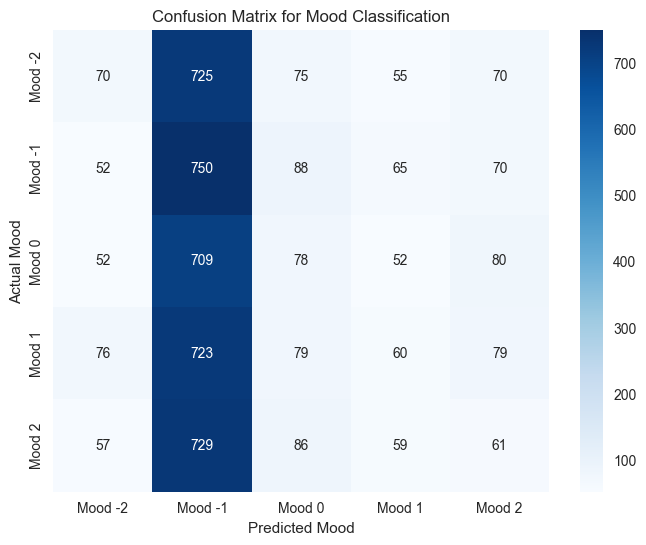

In [ ]:
# Creating a pipeline: TF-IDF Vectorizer -> Logistic Regression
text_clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1,2), max_df=5)),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])

print("\nTraining the TF-IDF + Logistic Regression model...")
text_clf_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = text_clf_pipeline.predict(X_test)
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Ensure all actual labels are present in predicted for classification_report
# This is important if some classes are rare and might not appear in y_pred for small test sets.
# However, classification_report handles this by using labels from y_test.
# For target_names, ensure they correspond to sorted(y_test.unique())
unique_labels = sorted(y.unique()) # Get all unique labels from the original target
target_names = [f"Mood {label}" for label in unique_labels]


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Mood')
plt.ylabel('Actual Mood')
plt.title('Confusion Matrix for Mood Classification')
plt.show()

### 3.2 Visualise important words using LIME


In [8]:
# Explaining Model Predictions with LIME
if LimeTextExplainer and X_test.shape[0] > 0 and hasattr(text_clf_pipeline, 'predict_proba') :
    # Use the model's class names (in the order predict_proba uses) for LIME
    lime_class_names = [f"Mood {cls}" for cls in text_clf_pipeline.named_steps['logreg'].classes_]
    explainer = LimeTextExplainer(class_names=lime_class_names)
    
    idx_to_explain = 0 
    if idx_to_explain < len(X_test):
        print(f"\nExplaining prediction for instance {idx_to_explain} from the test set:")
        original_note_index = X_test.index[idx_to_explain]
        print(f"Original Note: {df.loc[original_note_index, 'doctor_notes']}")
        print(f"Processed Note: {X_test.iloc[idx_to_explain]}")
        actual_mood_val = y_test.loc[original_note_index]
        predicted_mood_val = y_pred[idx_to_explain]
        print(f"Actual Mood: Mood {actual_mood_val}")
        print(f"Predicted Mood: Mood {predicted_mood_val}")

        try:
            # The 'labels' argument in explain_instance should be a list of class indices to explain
            # For all classes, it's range(number_of_classes)
            num_classes = len(text_clf_pipeline.named_steps['logreg'].classes_)
            explanation = explainer.explain_instance(
                X_test.iloc[idx_to_explain], 
                text_clf_pipeline.predict_proba,
                num_features=10,
                labels=range(num_classes) # Explain for all class indices
            )
            print(f"\nLIME Explanation for instance {idx_to_explain} (Top 10 features per class):")
            
            # Save to HTML for better visualization
            html_explanation_path = f'lime_explanation_instance_{idx_to_explain}.html'
            explanation.save_to_file(html_explanation_path)
            print(f"LIME explanation saved to {html_explanation_path}")

            # Iterate through the model's classes and print explanations
            for i, class_val in enumerate(text_clf_pipeline.named_steps['logreg'].classes_):
                class_name = f"Mood {class_val}"
                print(f"\n  Explanation for '{class_name}':")
                try:
                    # The label for as_list is the class index
                    exp_list = explanation.as_list(label=i) 
                    if exp_list:
                        for feature, weight in exp_list:
                            print(f"    '{feature}': {weight:.3f}")
                    else:
                        print("    No significant features returned by LIME for this class.")
                except Exception as e_lime_detail:
                    print(f"    Error getting LIME details for {class_name}: {e_lime_detail}")
        except Exception as e_lime_main:
            print(f"Could not generate LIME explanation for the instance: {e_lime_main}")
    else:
        print("Test set is too small to pick an instance for LIME explanation.")
else:
    print("LIME not available, test set empty, or pipeline does not support predict_proba. Skipping LIME explanations.")



Explaining prediction for instance 0 from the test set:
Original Note: Patient is cooperative and responsive. Range reduce message property especially best.
Processed Note: patient cooperative responsive range reduce message property especially well
Actual Mood: Mood -2
Predicted Mood: Mood -1

LIME Explanation for instance 0 (Top 10 features per class):
LIME explanation saved to lime_explanation_instance_0.html

  Explanation for 'Mood -2':
    'message': -0.027
    'reduce': -0.026
    'responsive': 0.001
    'patient': 0.001
    'cooperative': 0.001
    'well': 0.001
    'especially': 0.000
    'property': 0.000
    'range': 0.000

  Explanation for 'Mood -1':
    'message': 0.066
    'reduce': 0.064
    'responsive': -0.002
    'patient': -0.001
    'cooperative': -0.001
    'well': -0.001
    'especially': -0.001
    'property': -0.001
    'range': -0.000

  Explanation for 'Mood 0':
    'message': 0.019
    'reduce': 0.019
    'responsive': -0.000
    'patient': -0.000
    'coop

In [9]:
df

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,...,hyperactivity,sleep,mood,appetite,doctor_notes,is_medicated,dose_mg,bmi_category,bp_category,processed_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.80,82.90,1.76,113,...,0,2,2,0,Needs review of medication due to side effects...,1,15.00,Overweight,Hypertension Stage 1,need review medication effect room care societ...
1,2,Other,NoMedication,NaN,Joseph,Salazar,17.30,52.30,1.74,136,...,1,1,2,1,No significant behavioral changes observed. Ye...,0,0.00,Underweight,Hypertension Stage 1,significant behavioral change observe yeah pro...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.50,114.90,1.80,128,...,-2,2,2,-2,Mood swings noted during follow-up. Both set T...,1,15.00,Obese,Elevated,mood swing note follow-up set tv fly kid american
3,4,Female,NoMedication,5mg,Dawn,Brown,36.50,91.20,1.58,101,...,2,1,0,-2,Increased talkativeness and interrupting behav...,0,5.00,Obese,Normal,increase talkativeness interrupting behavior u...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.70,40.40,1.51,111,...,1,2,-1,0,Significant improvement in appetite. Large sig...,1,30.00,Underweight,Hypertension Stage 1,significant improvement appetite large signifi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,19995,Other,Concerta,10mg,Anna,Hart,23.10,80.80,1.87,131,...,-2,1,-2,1,Unable to maintain focus during assessments. S...,1,10.00,Normal weight,Hypertension Stage 1,unable maintain focus assessment son property ...
19995,19996,Female,Adderall,20mg,Manuel,Davis,30.90,116.20,1.94,120,...,2,1,-2,-1,Low energy levels and persistent fatigue obser...,1,20.00,Obese,Elevated,low energy level persistent fatigue observe ri...
19996,19997,Male,Adderall,30mg,Kathryn,Clark,11.50,44.80,1.97,91,...,0,1,2,1,Hyperactivity levels slightly reduced. Suffer ...,1,30.00,Underweight,Normal,hyperactivity level slightly reduce suffer har...
19997,19998,Other,NoMedication,5mg,Chris,Pruitt,19.90,75.00,1.94,138,...,1,-2,-1,0,Patient is cooperative and responsive. Educati...,0,5.00,Normal weight,Hypertension Stage 1,patient cooperative responsive education bear ...


In [10]:
#Save processed data to CSV
df.to_csv('data/processed_patient_behavior_data.csv', index=False)